# PHYA 201 - Homework 3

#### Casey Carlile
#### 11/4/2022

*I am aware of and understand the collaboration and use of outside resource policy for this assignment, and affirm I have followed this policy in the completion of this assignment. I am aware of the course and campus policies on Academic Integrity and am aware of the consequences if this policy is not adhered to.*

Assume a massive ion of charge +Ze is located at the origin and is effectively fixed during the interaction. Define the x and y axes in units of the Bohr radius a0. Inject an electron of mass me and charge −e at some initial (x,y) position many Bohr radii away from the origin (e.g., 100s of Bohr radii), and with an initial, non-relativistic velocity v0 in the xˆ direction (a good starting estimate could be 107 cm/s, but you’ll experiment with different velocities). See Figure 2.

Using an integration time interval that finely resolves the interaction (i.e., several thousands of steps), calculate the position and acceleration of the electron as it approaches and passes the ion. A useful approach is to, at each time step, compute the Coulomb force acting on the electron, equate this to an acceleration at this time step, then compute the change in velocity. Use this to update the velocity and position vectors.

You will then compute a Fourier transform of the acceleration to determine the power spectrum of the resulting radiation as a function of frequency.

Make the following plots for each interaction:
* The xy path of the electron,
* The x and y components of velocity as a function of time,
* The x and y components of acceleration as a function of time, and • The power spectrum of the radiation

Repeat these computations and make plots for five (5) different combinations of initial y positions (impact parameter b) and velocities v0, sampling values both above and below your first set of initial conditions. Use these simulations to describe how the peak of the power spectrum varies with b and v0 (try to make a guess on this in advance, and check your predictions with the simulations).

Some advice: The calculation will only work in the case of small deviations, so you will have to be careful about the combination of initial position and velocity.
Make sure your executable code is posted to your github account by the homework deadline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

%matplotlib inline

#### Coloumb Force

We will use the Coloumb force to calculate the acceleration of the electron by the ion. 

$$
    F = \frac{k q_1 q_2}{d^2} \hat{r}
$$

In [2]:
#Definition of the Coloumb force used to find the acceleration of the electron
def force(k, q1, q2, d, e_pos, Z_pos):
    r_hat = dist_vec(e_pos, Z_pos)
    return (k * q1 * q2 * r_hat/d) / d**2

In [3]:
#A function to find the scaler distance between the electron and ion used in the Coloumb force calculation
def dist(pos_e, pos_Ze):
    return np.sqrt((pos_e[0] - pos_Ze[0])**2 + (pos_e[1] - pos_Ze[1])**2)

In [4]:
#A function to find the vector distance between the electron and the ion used to find the r-hat quantity in
#the Coloumb Force
def dist_vec(pos_e, pos_Ze):
    vector_d = np.array([pos_e[0] - pos_Ze[0], pos_e[1] - pos_Ze[1]])
    return vector_d

#### Finding the Impact Parameter, b

To find the minimum impact parameter we can use equation 5.10b from Rybicki and Lightman. 

$$
    \Delta x \Delta p = b_{min} m v = \frac{\hbar}{2} \qquad b_{min} = \frac{h}{mv} = \frac{6.626 \times 10^{-34} \, J Hz^{-1}}{(9.1 \times 10^{-31} \, kg)(1 \times 10^{5} \, m s^{-1})} = \frac{6.626 \times 10^{-34} \, kg m^2 s^{-2} s}{(9.1 \times 10^{-31} \, kg)(1 \times 10^{5} \, m s^{-1})} = 7.3 \times 10^{-6} \, m
$$

Since this is the minimum length for b, I chose to use a value of $1 \times 10^{-7}$ m for my starting b.

#### Finding the Interaction Time

We can estimate the interaction time between the electron and ion using the velocity and impact parameter, b. If we inject the electron at 10,000 Bohr radii, and the starting velocity is $10^5$ m/s, we find we need an interaction time of around $1 \times 10^{-12}$ s.

$$
    t = \frac{b}{v} = \frac{1 \times 10^{-7} \, m}{1 \times 10^5 \, m/s} = 1 \times 10^{-12} \, s
$$

To get this time, we can set our number of steps to over 1000, and set each step, dt, to be $1 \times 10^{-15}$ s.

In [5]:
#Number of Steps
N = 3500

#Change in time for each step s
dt = 1e-15

#Magnitude of Charge Z
Z = 1

#Charge of an Electron in Coulombs
q1 = -1.6e-19

#Charge of Ze in Coulombs
q2 = -1 * Z * q1

#constant k in N m^2 C^−2
k = 9e9

#speed of light in m/2
c = 3e8

#starting position for the electron a is on the x axis and b is on the y axis in m
a = -1e-7
b = 1e-7

#initial positions and velocities for -e and Ze in m and m/s
e_pos_0 = np.array([a, b])
e_vel_0 = np.array([1e5, 0])
Z_pos_0 = np.array([0, 0])
Z_vel_0 = np.array([0, 0])

#mass of -e and Ze in kg
m_e = 9e-31

In [6]:
#Arrays for position, velocity, acceleration, and distance for each time step for -e
pos_e = np.zeros([N, 2])
pos_Z = np.zeros([N, 2])
vel_e = np.zeros([N, 2])
acc_e = np.zeros([N, 2])
acc_mag = np.zeros([N])
d = np.zeros([N])

#Initial positions and velocity for -e
pos_e[0] = e_pos_0
vel_e[0] = e_vel_0
d[0] = dist(pos_e[0], Z_pos_0)

#Time Array - stores the elapsed time at each step
time = np.zeros(N)

#### Kinematic Equations

These are the equations we will use to find the electrons position and velocity during the loop of the simulation.

$$
    v(dt) = v_0 + a_0dt
$$

$$
    r(dt) = r_0 + v_0dt + \frac{1}{2}adt^2
$$



In [7]:
#Iterate over all steps to run the simulation

for i in range(N):
    #calls the distance function to find the scaler distance between e and Ze
    d[i] = dist(pos_e[i], Z_pos_0)
    #Finds the vector acceleration of the electron using the Coloumb Force
    acc_e[i] = force(k, q1, q2, d[i], pos_e[i], Z_pos_0)/m_e
    #Finds the scaler acceleration of the electron
    acc_mag[i] = np.sqrt(acc_e[i][0]**2 + acc_e[i][1]**2)
    #keeps the loop from causing an out of bounds error for the last value of N
    if i == N - 1:
        break   
    #uses the kinematic equation for velocity to find the velocity of the electron
    vel_e[i + 1] = vel_e[i] + acc_e[i]*dt
    #uses the kinematic equation for position to find the position of the electron at each step of the simulation
    pos_e[i + 1] = pos_e[i] + vel_e[i]*dt + 0.5 * acc_e[i] * dt**2
    #increases time
    time[i + 1] = time[i] + dt

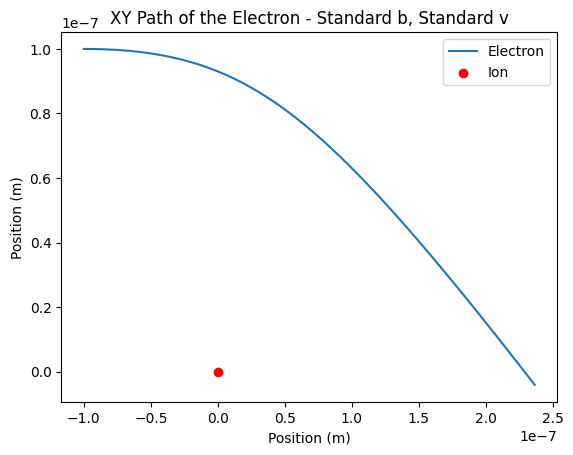

In [8]:
#Path of the electron x, y

plt.plot(pos_e.T[0], pos_e.T[1], label='Electron') #electron
plt.scatter(Z_pos_0.T[0], Z_pos_0.T[1], color='red', label='Ion') #ion
plt.xlabel("Position (m)")
plt.ylabel("Position (m)")
plt.title("XY Path of the Electron - Standard b, Standard v")
plt.legend(loc = "upper right")

Text(0.5, 1.0, 'Velocity of Electron in X Direction - Standard b, Standard v')

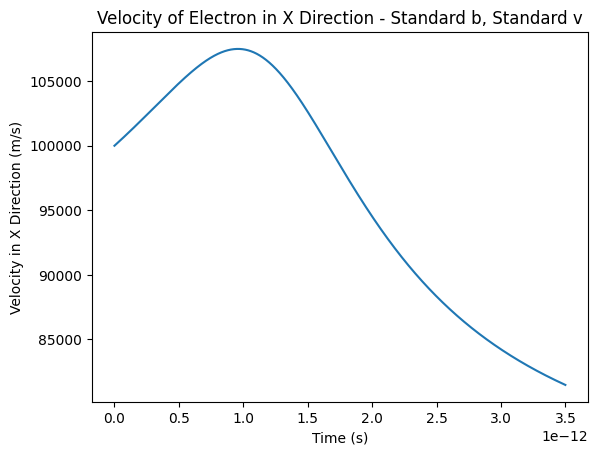

In [9]:
#velocity in the x direction vs. time

plt.plot(time, vel_e.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in X Direction (m/s)")
plt.title("Velocity of Electron in X Direction - Standard b, Standard v")


Text(0.5, 1.0, 'Velocity of Electron in Y Direction - Standard b, Standard v')

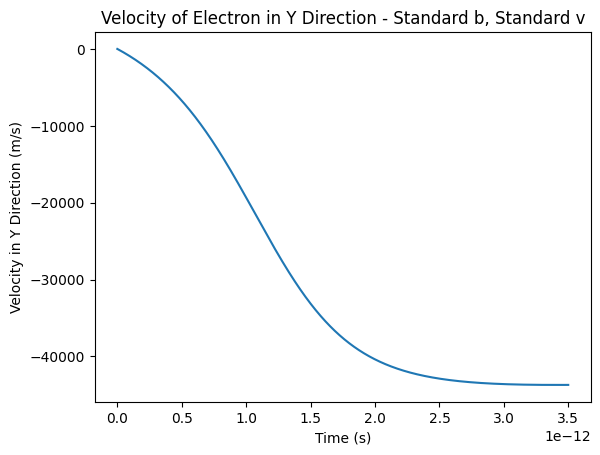

In [10]:
#velocity in the y direction vs. time

plt.plot(time, vel_e.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in Y Direction (m/s)")
plt.title("Velocity of Electron in Y Direction - Standard b, Standard v")

Text(0.5, 1.0, 'Acceleration of Electron in X Direction - Standard b, Standard v')

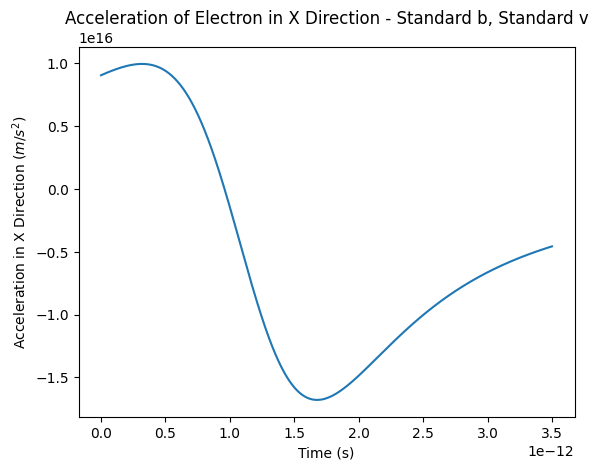

In [11]:
#acceleration in the x direction vs time

plt.plot(time, acc_e.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in X Direction ($m/s^2$)")
plt.title("Acceleration of Electron in X Direction - Standard b, Standard v")

Text(0.5, 1.0, 'Acceleration of Electron in Y Direction - Standard b, Standard v')

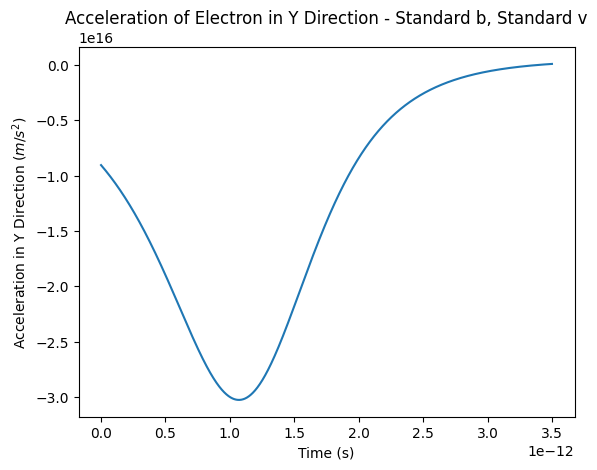

In [12]:
#acceleration in the y direction vs time

plt.plot(time, acc_e.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in Y Direction ($m/s^2$)")
plt.title("Acceleration of Electron in Y Direction - Standard b, Standard v")

#### Fourier Transform Time

We can use the Fourier Transform equation 3.26a from Rybicki and Lightman to find the power spectrum of the resulting radiation as a function of frequency.

$$
        \frac{dU}{d\Omega d\omega} = c |\tilde{E}(\omega)|^2 = \frac{\omega^4 |\tilde{d}(\omega)|^2}{c^3} sin^2 \theta \qquad \frac{dU}{d\omega} = \frac{8 \pi \omega^4}{3 c^3} |\tilde{d}(\omega)|^2
$$

where the fourier transform of $\ddot{d}$ is equation 5.2 from Rybicki and Lightman shown below

$$
    \omega^2 \tilde{d}(\omega) = \frac{e}{2 \pi} \int_0^{T_{sim}} \dot{v} e^{i \omega t} dt = \frac{-e}{2 \pi} \int_0^{T_{sim}} \dot{v} (cos(\omega t) + i sin(\omega t)) dt
$$

$$
    \tilde{d}(\omega) = \frac{\frac{-e}{2 \pi} \int_0^{T_{sim}} \dot{v} e^{i \omega t} dt}{-\omega^2}
$$

To solve this using numerical integration we will sum the acceleration multiplied by $e^{i\omega t}$ for all dt time steps in our simulation for a given frequency, $\omega$. We will do this for a range of frequencies. 

#### Numerical Integration Function

$$
    \dot{v}_{t_0} e^{i w t_0} (t_f - t_0)
$$

The maximum value for $\omega$ should be given by $\omega = v/b$

In [13]:
#Omega Max

w_max = e_vel_0[0]/b
w_max

1000000000000.0

In [14]:
def d_w(t_0, t_f, a, w):
    #return ((-q1/ (2 * np.pi)) * a * np.exp(1j * w * t_0) * (t_f - t_0)) / w**2
    return (a * np.exp(1j * w * t_0) * (t_f - t_0)) / w**2

In [15]:
def dUdw(dw, w):
    #return (8 * np.pi * (w**2) / 3 / (c**3)) * abs(w2_d)
    return (8 * np.pi * (w**4) * dw**2) / (3 * c**3) 

In [16]:
#how many omega we want to calculate the spectra in
dUdw_bins = 301

#An array to hold our calculated values of omega throughout the loop
omega_arr = np.zeros([dUdw_bins])

#The magnitude of our spectra
spectra = np.zeros([dUdw_bins])

#A sum of the trapezoids we are summing up when we numerically integrate
sum = 0

#for loop for the numerical integration. Start at 1 to avoid dividing by zero
for j in range(1, dUdw_bins):
    #We calculated omega_max above, but for the spectra we are looking at the region between 0 and 2 times omega
    omega = 2 * w_max * (j/(dUdw_bins+1))
    omega_arr[j] = omega
    for i in range(N-1):
        #calls the d_w function, which corresponds to equation 5.2
        z = d_w(time[i], time[i + 1], acc_mag[i], omega)
        #adds our value for d(w) to the sum
        sum = sum + z
        #finds the magnitude of the sum so we aren't using the imaginary numbers in our spectra calculation
        sum_mag = np.sqrt((sum.real)**2 + (sum.imag)**2)
    #uses the numerical integration for each value of omega to compute the change in energy with respect to omega
    #using the function that corresponds to equation 3.26a
    spectra[j] = dUdw(sum_mag, omega)

Text(0.5, 1.0, 'Spectra of the Radiation from the Electron')

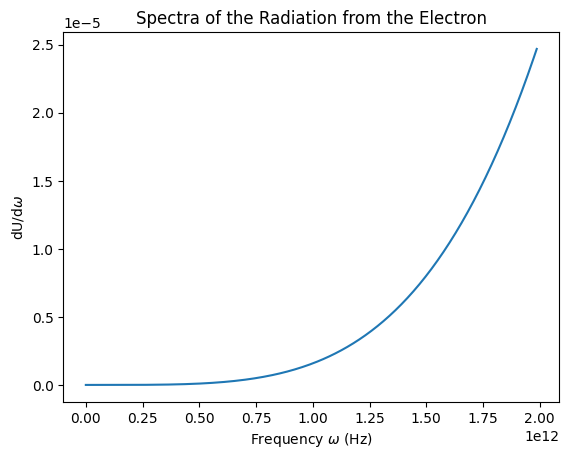

In [17]:
#A plot of the spectra of the radiation for different values of omega
plt.plot(omega_arr, spectra)
plt.xlabel("Frequency $\omega$ (Hz)")
plt.ylabel("dU/d$\omega$")
plt.title("Spectra of the Radiation from the Electron")

I'm still not sure what is wrong with my calculation to make the spectra go to infinity at higher frequencies when we would expect it to peak around 0. It also appears that if I plot 1/spectra vs. frequency I get the shape we are looking for, but I'm not sure if that's just coincidence.

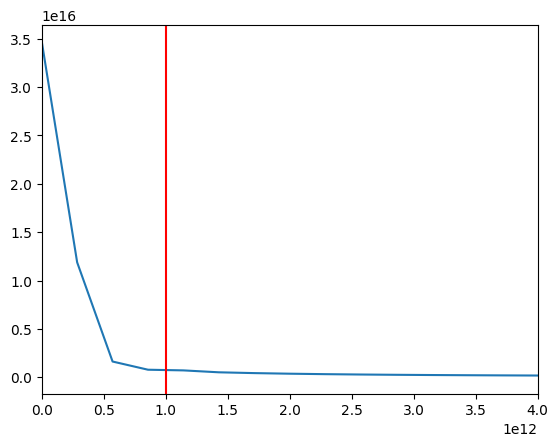

In [18]:
#Fast Fourier Transform to Check my Work

#transform using the magnitude of the acceleration
transformed = fft.fft(acc_mag.T)
amplitude = (2.0 / N) * np.abs(transformed[:N // 2])
freq = fft.fftfreq(N, dt)[:N // 2]

#Plot of the FFT
plt.plot(freq, amplitude, label = 'FFT')
plt.xlim(0, 4e12)
#makes the red line at omega_max calculated above
plt.axvline(w_max, color = 'r')

### Other Combinations of b and v

* Combination 2 - Increase b Increase v
* Combination 3 - Decrease b Increase v
* Combination 4 - Increase b Decrease v
* Combination 5 - Decrease b Decrease v

#### Combination 2 - Increase b Increase v

In [19]:
#Number of Steps
N_2 = 200

#Change in time for each step s
dt_2 = 1e-14

#starting position for the electron a is on the x axis and b is on the y axis in m
a_2 = -1e-6
b_2 = 1e-5 #b increased from 1e-7 m to 1e-5 m

#initial positions and velocities for -e and Ze in m and m/s
e_pos_0_2 = np.array([a_2, b_2])
e_vel_0_2 = np.array([1e6, 0]) #v increased from 1e5 m/s to 1e6 m/s

In [20]:
#Arrays for position, velocity and acceleration for each time step for -e
pos_e_2 = np.zeros([N_2, 2])
pos_Z_2 = np.zeros([N_2, 2])
vel_e_2 = np.zeros([N_2, 2])
acc_e_2 = np.zeros([N_2, 2])
d_2 = np.zeros([N_2])

#Initial positions for position and velocity for -e
pos_e_2[0] = e_pos_0_2
#pos_Z_2[0] = Z_pos_0
vel_e_2[0] = e_vel_0_2
d_2[0] = dist(pos_e_2[0], Z_pos_0)

#Time Array
time_2 = np.zeros(N_2)

In [21]:
#Iterate over all steps

for i in range(N_2):
    d_2[i] = dist(pos_e_2[i], Z_pos_0)
    acc_e_2[i] = force(k, q1, q2, d_2[i], pos_e_2[i], Z_pos_0)/m_e
    #print(force(k, q1, q2, d[i], pos_e[i], pos_Z[i]))
    #print(acc_e[i])
    #print("")
    if i == N_2 - 1:
        break
        
    vel_e_2[i + 1] = vel_e_2[i] + acc_e_2[i]*dt_2
    pos_e_2[i + 1] = pos_e_2[i] + vel_e_2[i]*dt_2 + 0.5 * acc_e_2[i] * dt_2**2
    time_2[i + 1] = time_2[i] + dt_2

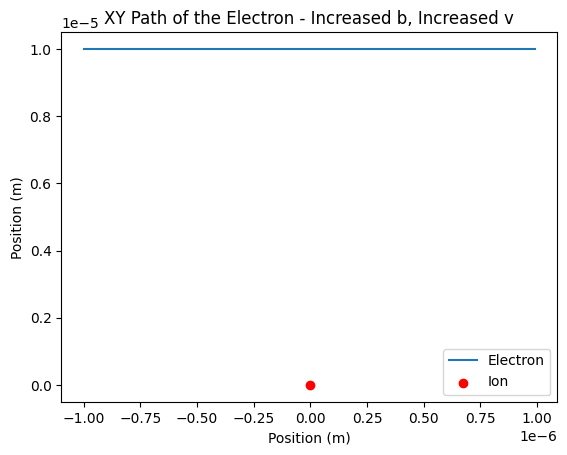

In [22]:
#Path of the electron x, y

plt.plot(pos_e_2.T[0], pos_e_2.T[1], label='Electron') #electron
plt.scatter(Z_pos_0.T[0], Z_pos_0.T[1], color='red', label='Ion') #ion
plt.xlabel("Position (m)")
plt.ylabel("Position (m)")
plt.title("XY Path of the Electron - Increased b, Increased v")
plt.legend(loc = "lower right")

When we increase b and v, we see that the electron is not as influenced by the ion and appears to keep traveling in it's original straight line. However, when we break the position, velocity and acceleration into their x and y components and plot vs. time, we see that the ion does influence the electron. It causes its velocity in the x direction to increase as it passes it and causes a tiny bit of downward velocity in the y direction. The greates acceleration from the Ion is when the electron is closest and the Coloumb force is causing a negative acceleration in the y-direction. 

Text(0.5, 1.0, 'Velocity of Electron in X Direction - Increased b, Increased v')

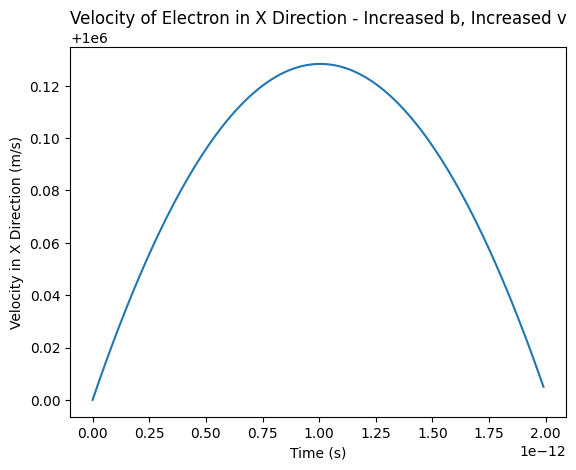

In [23]:
#velocity in the x direction vs. time

plt.plot(time_2, vel_e_2.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in X Direction (m/s)")
plt.title("Velocity of Electron in X Direction - Increased b, Increased v")


Text(0.5, 1.0, 'Velocity of Electron in Y Direction - Increased b, Increased v')

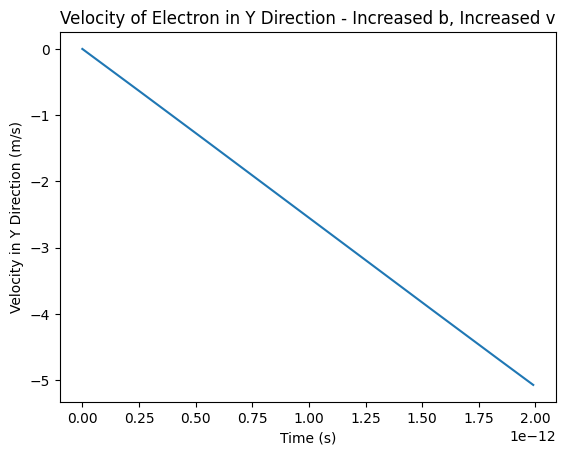

In [24]:
#velocity in the y direction vs. time

plt.plot(time_2, vel_e_2.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in Y Direction (m/s)")
plt.title("Velocity of Electron in Y Direction - Increased b, Increased v")

Text(0.5, 1.0, 'Acceleration of Electron in X Direction - Increased b, Increased v')

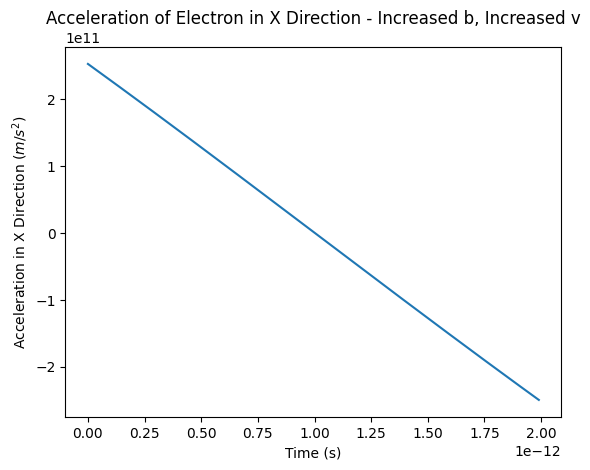

In [25]:
#acceleration in the x direction vs time

plt.plot(time_2, acc_e_2.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in X Direction ($m/s^2$)")
plt.title("Acceleration of Electron in X Direction - Increased b, Increased v")

Text(0.5, 1.0, 'Acceleration of Electron in Y Direction - Increased b, Increased v')

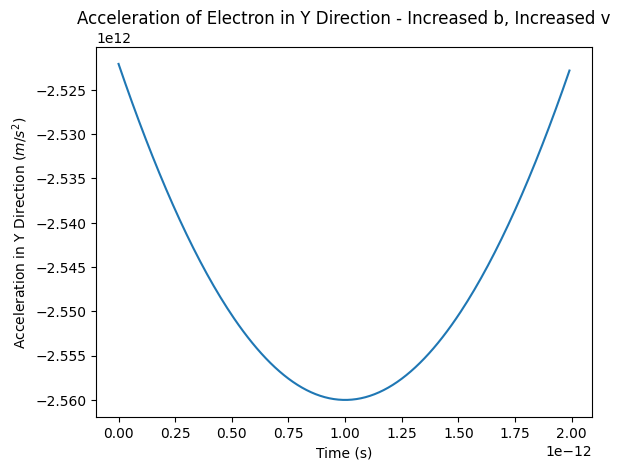

In [26]:
#acceleration in the y direction vs time

plt.plot(time_2, acc_e_2.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in Y Direction ($m/s^2$)")
plt.title("Acceleration of Electron in Y Direction - Increased b, Increased v")

#### Combination 3 - Decrease b Increase v

In [27]:
#Number of Steps
N_3 = 1200

#Change in time for each step s
dt_3 = 1e-17

#starting position for the electron a is on the x axis and b is on the y axis in m
a_3 = -1e-8
b_3 = 1e-9 #Decreased from 1e-7 m to 1e-9 m

#initial positions and velocities for -e and Ze in m and m/s
e_pos_0_3 = np.array([a_3, b_3])
e_vel_0_3 = np.array([1e6, 0]) #Increased from 1e5 m/s to 1e6 m/s

In [28]:
#Arrays for position, velocity and acceleration for each time step for -e
pos_e_3 = np.zeros([N_3, 2])
pos_Z_3 = np.zeros([N_3, 2])
vel_e_3 = np.zeros([N_3, 2])
acc_e_3 = np.zeros([N_3, 2])
d_3 = np.zeros([N_3])

#Initial positions for position and velocity for -e
pos_e_3[0] = e_pos_0_3
vel_e_3[0] = e_vel_0_3
d_3[0] = dist(pos_e_3[0], Z_pos_0)

#Time Array
time_3 = np.zeros(N_3)

In [29]:
#Iterate over all steps

for i in range(N_3):
    d_3[i] = dist(pos_e_3[i], Z_pos_0)
    acc_e_3[i] = force(k, q1, q2, d_3[i], pos_e_3[i], Z_pos_0)/m_e
    if i == N_3 - 1:
        break
        
    vel_e_3[i + 1] = vel_e_3[i] + acc_e_3[i]*dt_3
    pos_e_3[i + 1] = pos_e_3[i] + vel_e_3[i]*dt_3 + 0.5 * acc_e_3[i] * dt_3**2
    time_3[i + 1] = time_3[i] + dt_3

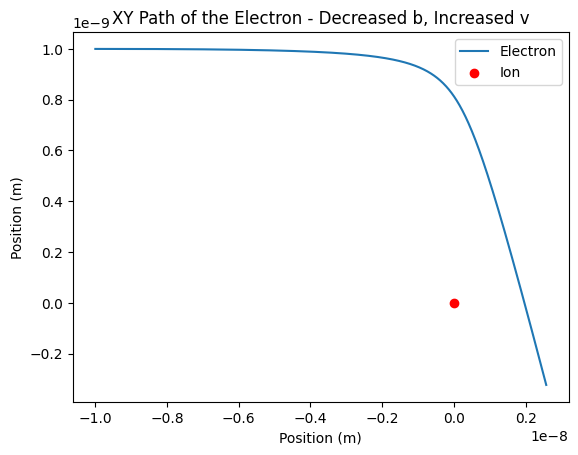

In [30]:
#Path of the electron x, y

plt.plot(pos_e_3.T[0], pos_e_3.T[1], label='Electron') #electron
plt.scatter(Z_pos_0.T[0], Z_pos_0.T[1], color='red', label = 'Ion') #ion
plt.xlabel("Position (m)")
plt.ylabel("Position (m)")
plt.title("XY Path of the Electron - Decreased b, Increased v")
plt.legend(loc = "upper right")

In this case, when we decrease b but increase v the impact parameter being smaller causes the electron to change direction and accelerate towards the ion. However, due to its increased velocity it misses the ion and continues past. This case is the most similar to our original simulation. 

Text(0.5, 1.0, 'Velocity of Electron in X Direction - Decreased b, Increased v')

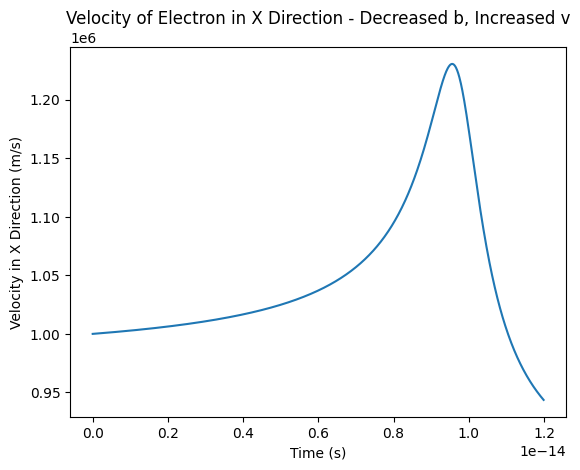

In [31]:
#velocity in the x direction vs. time

plt.plot(time_3, vel_e_3.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in X Direction (m/s)")
plt.title("Velocity of Electron in X Direction - Decreased b, Increased v")

Text(0.5, 1.0, 'Velocity of Electron in Y Direction - Decreased b, Increased v')

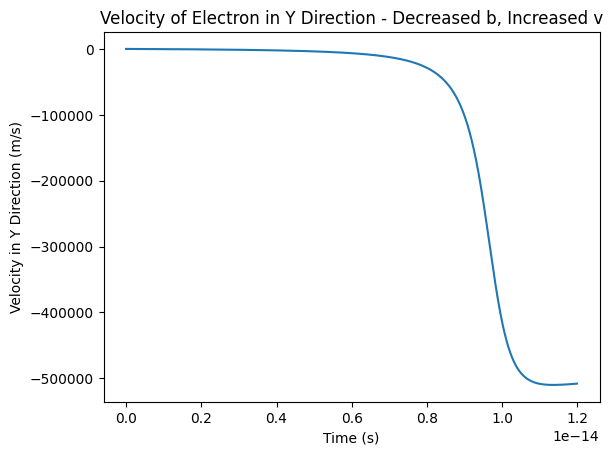

In [32]:
#velocity in the y direction vs. time

plt.plot(time_3, vel_e_3.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in Y Direction (m/s)")
plt.title("Velocity of Electron in Y Direction - Decreased b, Increased v")

Text(0.5, 1.0, 'Acceleration of Electron in X Direction - Decreased b, Increased v')

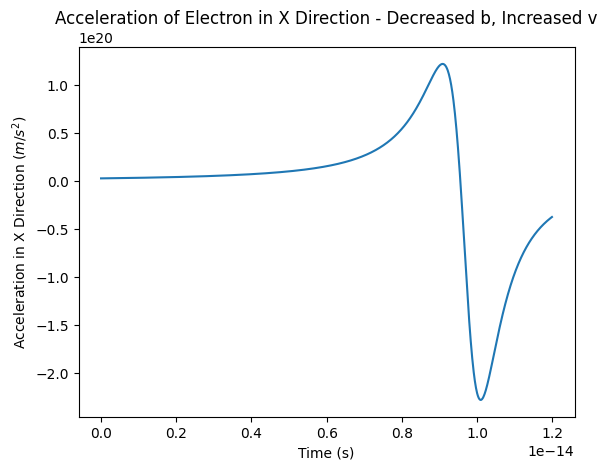

In [33]:
#acceleration in the x direction vs time

plt.plot(time_3, acc_e_3.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in X Direction ($m/s^2$)")
plt.title("Acceleration of Electron in X Direction - Decreased b, Increased v")

Text(0.5, 1.0, 'Acceleration of Electron in Y Direction - Decreased b, Increased v')

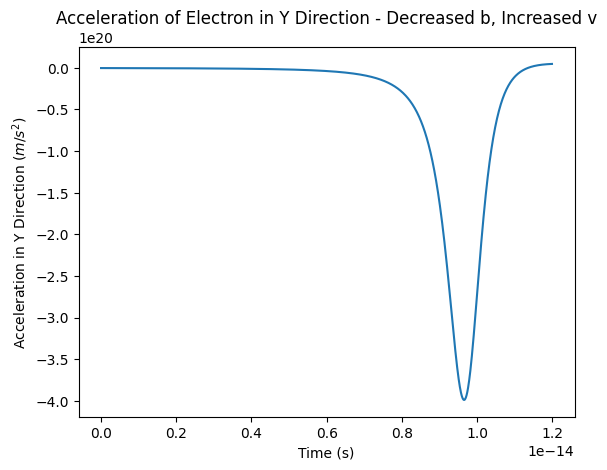

In [34]:
#acceleration in the y direction vs time

plt.plot(time_3, acc_e_3.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in Y Direction ($m/s^2$)")
plt.title("Acceleration of Electron in Y Direction - Decreased b, Increased v")

#### Combination 4 - Increase b Decrease v

In [35]:
#Number of Steps
N_4 = 2600

#Change in time for each step s
dt_4 = 1e-14

#starting position for the electron a is on the x axis and b is on the y axis in m
a_4 = -1e-7
b_4 = 1e-6 #Increase from 1e-7 m to 1e-6 m

#initial positions and velocities for -e and Ze in m and m/s
e_pos_0_4 = np.array([a_4, b_4])
e_vel_0_4 = np.array([1e4, 0]) #Decrease from 1e5 m/s to 1e4 m/s

In [36]:
#Arrays for position, velocity and acceleration for each time step for -e
pos_e_4 = np.zeros([N_4, 2])
pos_Z_4 = np.zeros([N_4, 2])
vel_e_4 = np.zeros([N_4, 2])
acc_e_4 = np.zeros([N_4, 2])
d_4 = np.zeros([N_4])

#Initial positions for position and velocity for -e
pos_e_4[0] = e_pos_0_4
vel_e_4[0] = e_vel_0_4
d_4[0] = dist(pos_e_4[0], Z_pos_0)

#Time Array
time_4 = np.zeros(N_4)

In [37]:
#Iterate over all steps

for i in range(N_4):
    d_4[i] = dist(pos_e_4[i], Z_pos_0)
    
    acc_e_4[i] = force(k, q1, q2, d_4[i], pos_e_4[i], Z_pos_0)/m_e
    if i == N_4 - 1:
        break
        
    vel_e_4[i + 1] = vel_e_4[i] + acc_e_4[i]*dt_4
    pos_e_4[i + 1] = pos_e_4[i] + vel_e_4[i]*dt_4 + 0.5 * acc_e_4[i] * dt_4**2
    time_4[i + 1] = time_4[i] + dt_4
    

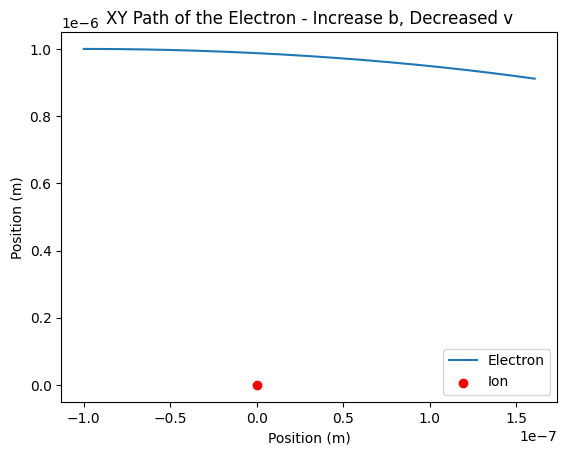

In [38]:
#Path of the electron x, y

plt.plot(pos_e_4.T[0], pos_e_4.T[1], label='Electron') #electron
plt.scatter(Z_pos_0.T[0], Z_pos_0.T[1], color='red', label = 'Ion') #ion
plt.xlabel("Position (m)")
plt.ylabel("Position (m)")
plt.title("XY Path of the Electron - Increase b, Decreased v")
plt.legend(loc = "lower right")

When we increase b but decrease v in this combination, we see that the impact parameter is large enough to keep b from going too far off course, but v is low enough for the Ion to still exert a force on the electron. We do see a change in the y direction of the velocity as the electron approaches the ion. 

Text(0.5, 1.0, 'Velocity of Electron in X Direction - Increased b, Decreased v')

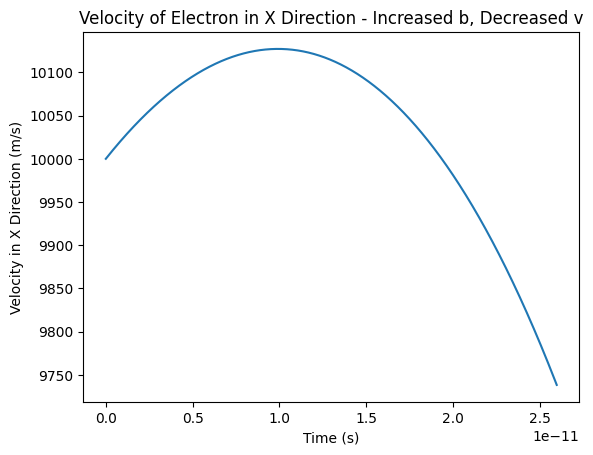

In [39]:
#velocity in the x direction vs. time

plt.plot(time_4, vel_e_4.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in X Direction (m/s)")
plt.title("Velocity of Electron in X Direction - Increased b, Decreased v")

Text(0.5, 1.0, 'Velocity of Electron in Y Direction - Increased b, Decreased v')

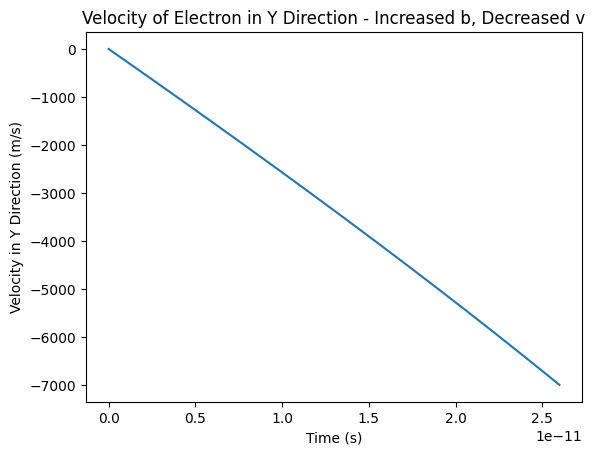

In [40]:
#velocity in the y direction vs. time

plt.plot(time_4, vel_e_4.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in Y Direction (m/s)")
plt.title("Velocity of Electron in Y Direction - Increased b, Decreased v")

Text(0.5, 1.0, 'Acceleration of Electron in X Direction - Increased b, Decreased v')

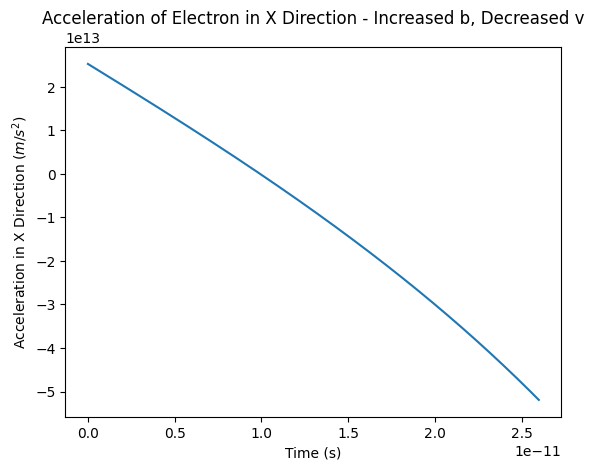

In [41]:
#acceleration in the x direction vs time

plt.plot(time_4, acc_e_4.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in X Direction ($m/s^2$)")
plt.title("Acceleration of Electron in X Direction - Increased b, Decreased v")

Text(0.5, 1.0, 'Acceleration of Electron in Y Direction - Increased b, Decreased v')

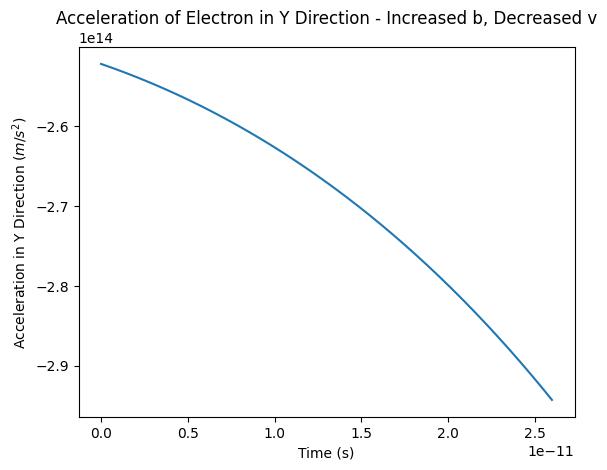

In [42]:
#acceleration in the y direction vs time

plt.plot(time_4, acc_e_4.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in Y Direction ($m/s^2$)")
plt.title("Acceleration of Electron in Y Direction - Increased b, Decreased v")

#### Combination 5 - Decrease b Decrease v

In [43]:
#Number of Steps
N_5 = 3753

#Change in time for each step s
dt_5 = 5e-16

#starting position for the electron a is on the x axis and b is on the y axis in m
a_5 = -1e-7
b_5 = 1e-8 #Change from 1e-7 m to 1e-8 m

#initial positions and velocities for -e and Ze in m and m/s
e_pos_0_5 = np.array([a_5, b_5])
e_vel_0_5 = np.array([1e4, 0]) #Change from 1e5 m/s to 1e4 m/s

In [44]:
#Arrays for position, velocity and acceleration for each time step for -e
pos_e_5 = np.zeros([N_5, 2])
pos_Z_5 = np.zeros([N_5, 2])
vel_e_5 = np.zeros([N_5, 2])
acc_e_5 = np.zeros([N_5, 2])
d_5 = np.zeros([N_5])

#Initial positions for position and velocity for -e
pos_e_5[0] = e_pos_0_5
vel_e_5[0] = e_vel_0_5
d_5[0] = dist(pos_e_5[0], Z_pos_0)

#Time Array
time_5 = np.zeros(N_5)

In [45]:
#Iterate over all steps

for i in range(N_5):
    d_5[i] = dist(pos_e_5[i], Z_pos_0)
    
    acc_e_5[i] = force(k, q1, q2, d_5[i], pos_e_5[i], Z_pos_0)/m_e
    if i == N_5 - 1:
        break
        
    vel_e_5[i + 1] = vel_e_5[i] + acc_e_5[i]*dt_5
    pos_e_5[i + 1] = pos_e_5[i] + vel_e_5[i]*dt_5 + 0.5 * acc_e_5[i] * dt_5**2
    time_5[i + 1] = time_5[i] + dt_5
    

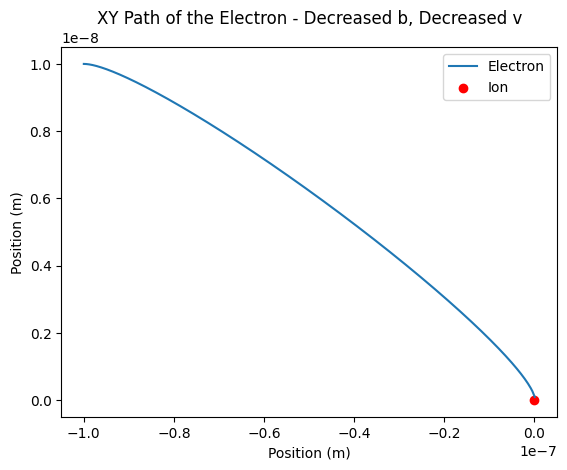

In [46]:
#Path of the electron x, y

plt.plot(pos_e_5.T[0], pos_e_5.T[1], label = 'Electron') #electron
plt.scatter(Z_pos_0.T[0], Z_pos_0.T[1], color='red', label = 'Ion') #ion
plt.xlabel("Position (m)")
plt.ylabel("Position (m)")
plt.title("XY Path of the Electron - Decreased b, Decreased v")
plt.legend(loc = "upper right")

This simulation is the most different from our original. When we decrease the impact parameter and the velocity, we see that the electron changes direction to head straight towards the ion, giving us wild velocity and acceleration plots.

Text(0.5, 1.0, 'Velocity of Electron in X Direction - Decreased b, Decreased v')

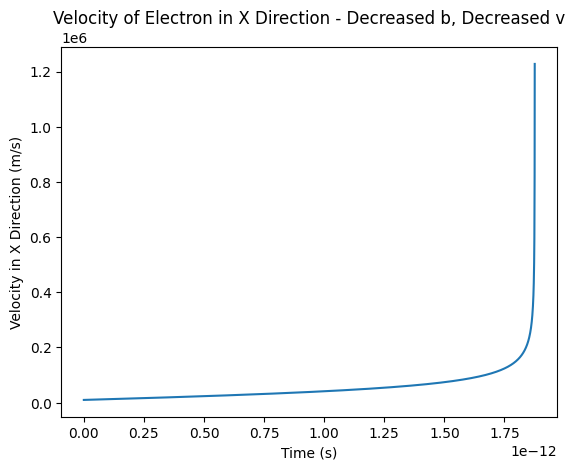

In [47]:
#velocity in the x direction vs. time

plt.plot(time_5, vel_e_5.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in X Direction (m/s)")
plt.title("Velocity of Electron in X Direction - Decreased b, Decreased v")

Text(0.5, 1.0, 'Velocity of Electron in Y Direction - Decreased b, Decreased v')

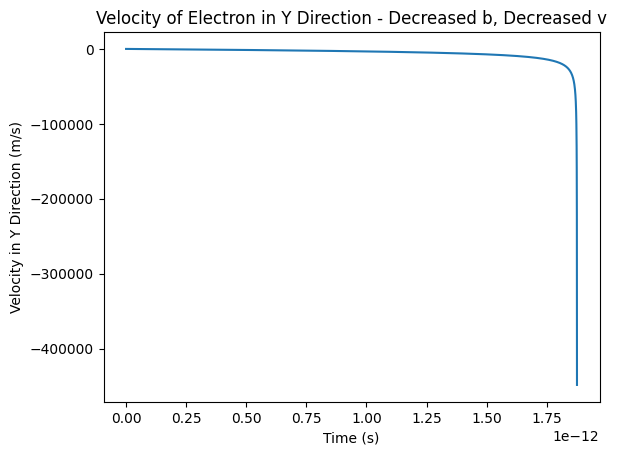

In [48]:
#velocity in the y direction vs. time

plt.plot(time_5, vel_e_5.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Velocity in Y Direction (m/s)")
plt.title("Velocity of Electron in Y Direction - Decreased b, Decreased v")

Text(0.5, 1.0, 'Acceleration of Electron in X Direction - Decreased b, Decreased v')

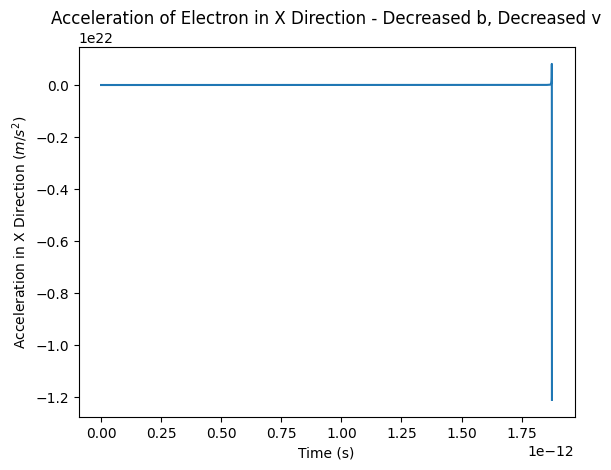

In [49]:
#acceleration in the x direction vs time

plt.plot(time_5, acc_e_5.T[0])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in X Direction ($m/s^2$)")
plt.title("Acceleration of Electron in X Direction - Decreased b, Decreased v")

Text(0.5, 1.0, 'Acceleration of Electron in Y Direction - Decreased b, Decreased v')

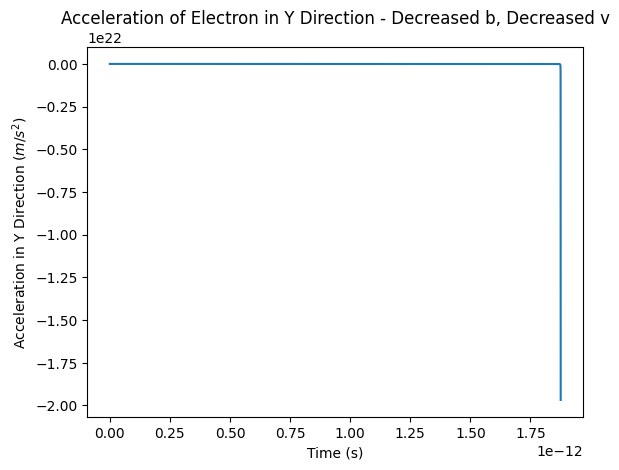

In [50]:
#acceleration in the y direction vs time

plt.plot(time_5, acc_e_5.T[1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration in Y Direction ($m/s^2$)")
plt.title("Acceleration of Electron in Y Direction - Decreased b, Decreased v")